[24ANN] 7조
- 20201588 박태현
- 20201590 송준규
- 20201596 양은주
- 20201610 정하연

# 1. Get the data/Discover and visualize the data
- MNIST extended dataset 개요 및 분석
- 여러 종류의 dataset 중 하나를 선택 (근거 제시)

## 1) EMNIST 논문 참고하기
- 논문 제목: EMNIST: an extension of MNIST to handwritten letters
- 논문 링크: https://arxiv.org/pdf/1702.05373v1

### I. BackGround (NIST, MNIST, EMNIST)
- NIST: 원래 데이터셋
- MNIST: NIST 데이터셋을 수정하여 '숫자' 이미지에 중점은 둔 데이터셋
- EMNIST: MNIST를 확장하여 '알파벳' 문자도 포함한 데이터셋

### II. Methodology
#### A. NIST에서 EMNIST로의 Transform (=Conversion Process)
***" The conversion process transforms the 128 × 128 pixel
binary images found in the NIST dataset to 28 × 28 pixel
images with an 8-bit gray-scale resolution that match the characteristics of the digits in the MNIST dataset. (변환 과정은 NIST 데이터셋에 있는 128 × 128 픽셀의 이진 이미지를 MNIST 데이터셋에 있는 숫자의 특성과 일치하도록 28 × 28 픽셀의 8비트 흑백 이미지로 변환합니다.)"***

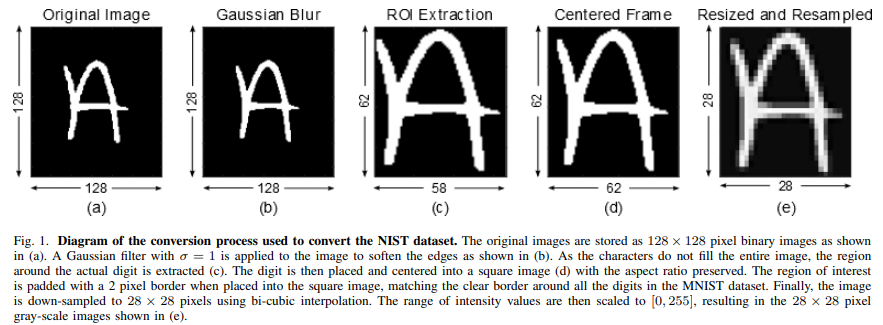

- (a) 이미지는 NIST 데이터셋 128 x 128 이진 이미지(binary image)이다.
- 글자의 가장자리 부분을 부드럽게 만들기 위해 σ=1
인 가우시안 필터를 적용한 결과 이미지가 (b)이다.
- 글자 부분만 전체 이미지 중 사용하고 싶은 부분이므로 이 관심 영역(region of interest, ROI)만 추출한 이미지가 (c)이다.
- 종횡비를 유지하며 이 글자를 이미지의 중앙에 놓는 정사각형 이미지가 생성되고 이 때 MNIST와 호환을 고려해서 1 픽셀 padding을 붙이게 되는데 이 이미지가 (d)이다.
- 마지막으로 28 x 28 크기의 8-bit 회색조 이미지(gray scale)를 만들기 위해 bi-cubic interpolation 다운샘플링 방법을 사용하고 밝기값(intensity values)의 범위를 [0, 255]로 놓은 이미지가 (e)이다.

- 이 전체적인 변환 프로세스는 MNIST와 일치하지만, ROI 추출 방법과 다운샘플링 방법에 차이가 있다.

- 번역 출처: https://kh-mo.github.io/papers/2020/08/26/emnist/

#### B. Training and Testing Splits
- The handwriting data used in the Special Database 19 was collected from both Census employees and high-school students.
- it does raise questions as to whether there is enough similarity and consistency between the two sets of participants.
- The creation of the EMNIST dataset therefore follows the same methodology used in the original MNIST paper in which **the original training and testing sets were combined and a new random training and testing set were drawn.**
-  The resulting training and testing datasets thereby **contain samples from both the high-school students and the census employees.**

#### C. The EMNIST Datasets
- Four additional subsets of these dataset were produced (compared to MNIST)
- The figure below shows **the included classes and number of samples per class** in each of the six datasets. Additionally, it shows **the training and testing splits for each datasets.**

    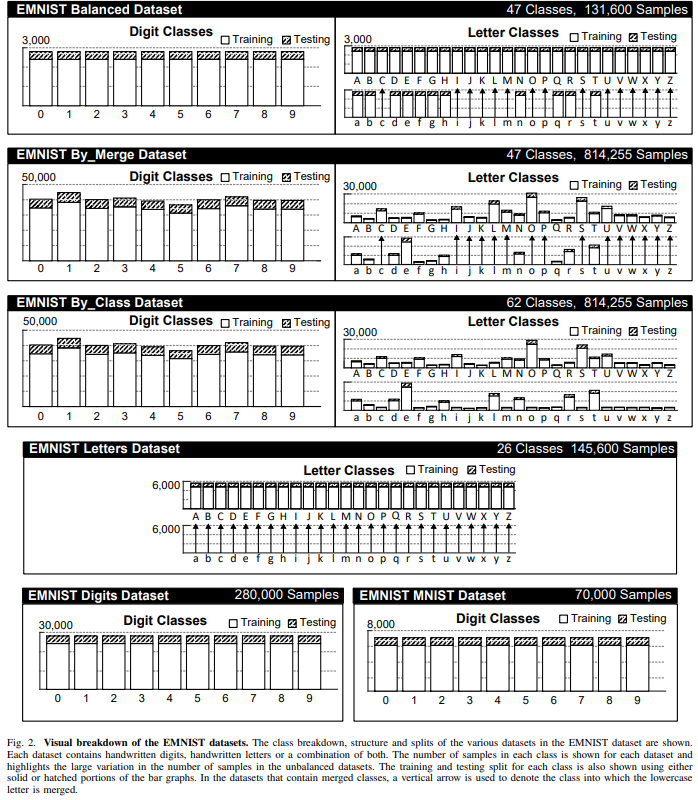

### D. Validation Partitions
- Table II contains a summary of the EMNIST datasets and **indicates which classes contain a validation subset in the training set.**
- In these datasets, **the last portion of the training set, equal in size to the testing set, is set aside as a validation set.**
- Additionally, this subset is also balanced such that it contains an equal number of samples for each task. If the validation set is not to be used, then the training set can be used as one contiguous set.

    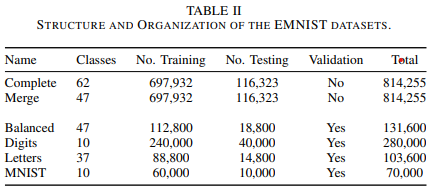

### III. Results

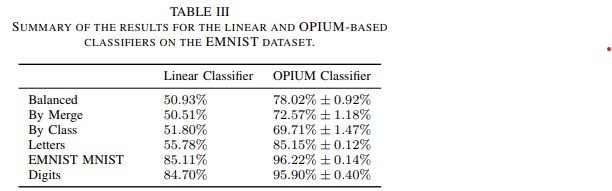

- OPIUM
    - Online Pseudo-Inverse Update Method
    - This method iteratively calculates the exact pseudo-inverse solution for the output weights and allows the network to handle datasets of any size.
- The accuracy of each classification task increased with the size of the hidden layer in the network, resulting in **a best performance with network sizes of 10,000 hidden layer neurons.**
- Due to memory and processing constraints, it was not possible to explore larger networks.

## 2) Multi-GPU 할당 설정

In [82]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"  # 사용할 GPU 번호 지정

# GPU 장치 목록 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')

# GPU 수 확인
gpu_count = len(gpus)
print("Number of GPUs:", gpu_count)

Number of GPUs: 3


## 3) Getting the EMNIST from Kaggle
- https://www.kaggle.com/datasets/crawford/emnist/data에서 emnist 폴더로 다운로드
- EMNIST 데이터셋의 이미지는 가로로 반전되고 시계 반대 방향으로 90도 회전되어 있음. (rotate 함수로 처리)
- 이미지 데이터를 0과 1사이의 값으로 정규화(normalization)함.
    - 이미지 픽셀 값은 0에서 255 사이의 값을 가진다.
    - 입력 픽셀 값을 동일한 범위로 조정하여 학습 시 더 빠른 수렴을 목적으로 한다.
    - 픽셀 값이 너무 크지 않도록 제한되어 연산 중에 오버플로우가 방지된다.

In [2]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

In [17]:
# Constants
HEIGHT = 28
WIDTH = 28

In [16]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [136]:
# 클래스별로 예시 이미지 출력
def plot_class_examples(images, labels, class_names, mapp):
    num_classes = len(class_names)
    num_rows = (num_classes // 10) + 1  # 최대 10개의 열을 가진 subplot의 행의 개수 계산
    num_cols = min(num_classes, 10)  # 최대 10개의 열을 가진 subplot의 열의 개수는 최대 클래스 개수까지
    
    plt.figure(figsize=(15, 2 * num_rows))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        example_index = class_indices[0] if class_indices.size > 0 else None  # 클래스에 속한 이미지가 있는지 확인

        plt.subplot(num_rows, num_cols, i + 1)
        if example_index is not None:
            plt.imshow(images[example_index], cmap='gray')
            plt.axis('off')
            
            # 이미지와 텍스트의 좌우 정렬을 위해 text 위치 조정
            image_width = images[example_index].shape[1]
            class_text = 'Class: {}'.format(class_name)
            label_text = 'Label: {}'.format(chr(mapp[class_name]))
            plt.text(image_width // 2, images[example_index].shape[0] + 10, class_text, fontsize=10, ha='center')
            plt.text(image_width // 2, images[example_index].shape[0] + 20, label_text, fontsize=10, ha='center')
        else:
            plt.text(0.5, 0.5, 'No image', fontsize=10, ha='center', va='center')
            plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # subplot 간격 조정
    plt.show()

### (a) byclass (complete)

In [3]:
train_byclass = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/byclass/emnist-byclass-train.csv",delimiter = ',')
test_byclass = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/byclass/emnist-byclass-test.csv", delimiter = ',')
mapp_byclass = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/byclass/emnist-byclass-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train_byclass.shape, test_byclass.shape, mapp_byclass.shape))

Train: (697931, 785), Test: (116322, 785), Map: (62,)


In [10]:
# Split x and y
train_x_byclass = train_byclass.iloc[:,1:]
train_y_byclass = train_byclass.iloc[:,0]
del train_byclass

test_x_byclass = test_byclass.iloc[:,1:]
test_y_byclass = test_byclass.iloc[:,0]
del test_byclass

print(train_x_byclass.shape, train_y_byclass.shape, test_x_byclass.shape, test_y_byclass.shape)

(697931, 784) (697931,) (116322, 784) (116322,)


In [23]:
# Flip and rotate image for byclass dataset
train_x_byclass = np.asarray(train_x_byclass)
train_x_byclass = np.apply_along_axis(rotate, 1, train_x_byclass)
print("train_x_byclass:", train_x_byclass.shape)

test_x_byclass = np.asarray(test_x_byclass)
test_x_byclass = np.apply_along_axis(rotate, 1, test_x_byclass)
print("test_x_byclass:", test_x_byclass.shape)

# Normalize
train_x_byclass = train_x_byclass.astype('float32')
train_x_byclass /= 255
test_x_byclass = test_x_byclass.astype('float32')
test_x_byclass /= 255


train_x_byclass: (697931, 28, 28)
test_x_byclass: (116322, 28, 28)


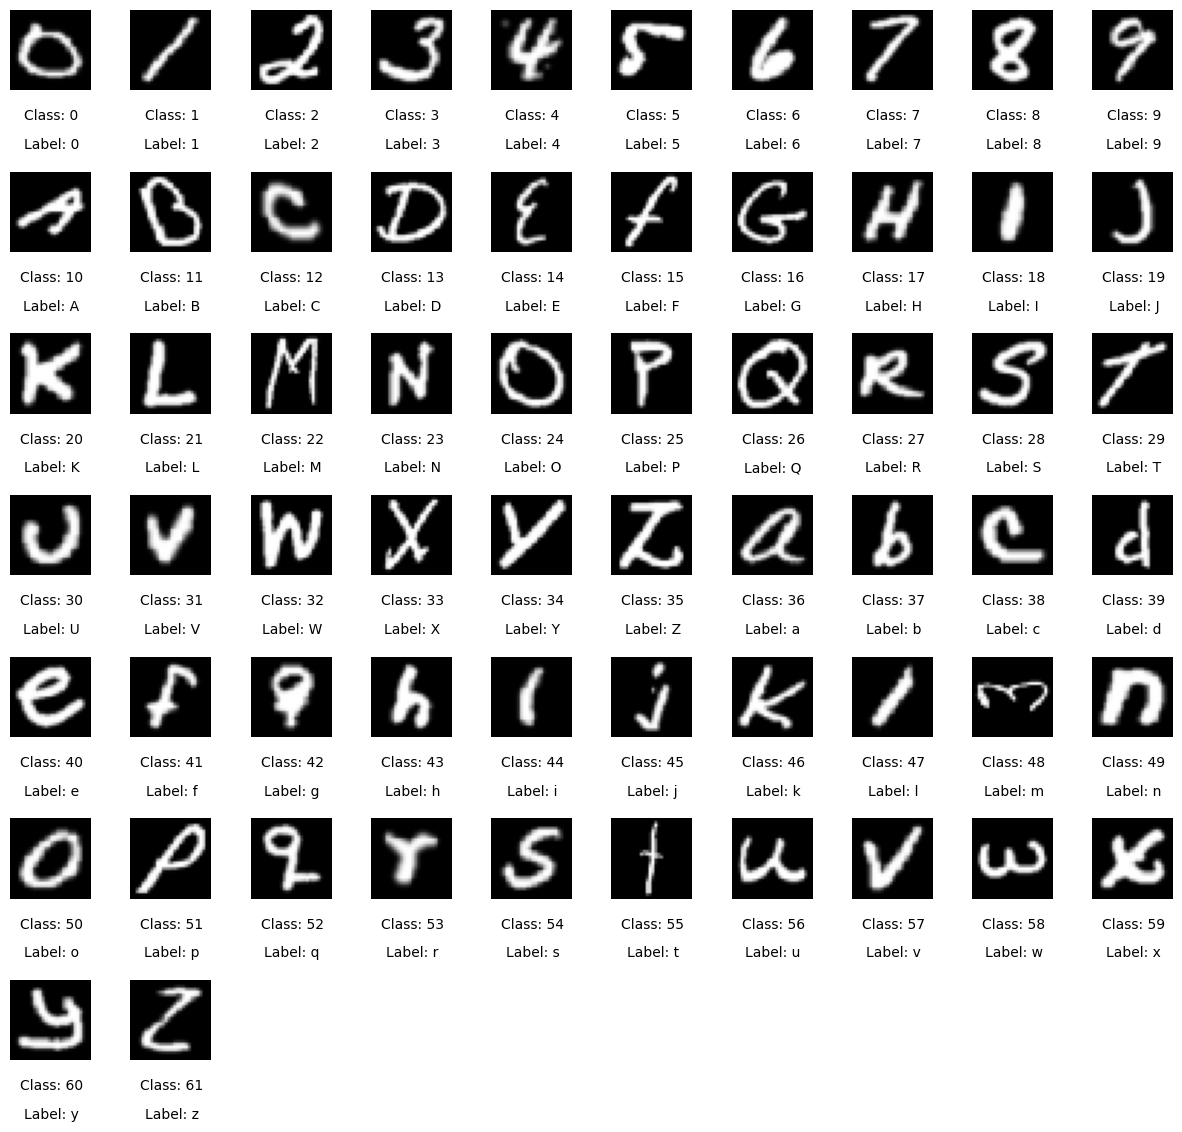

In [72]:
# 클래스 이름 추출
class_names = sorted(train_y_byclass.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_byclass, train_y_byclass, class_names, mapp_byclass)

### (b) bymerge

In [4]:
train_bymerge = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/bymerge/emnist-bymerge-train.csv",delimiter = ',')
test_bymerge = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/bymerge/emnist-bymerge-test.csv", delimiter = ',')
mapp_bymerge = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/bymerge/emnist-bymerge-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train_bymerge.shape, test_bymerge.shape, mapp_bymerge.shape))

Train: (697931, 785), Test: (116322, 785), Map: (47,)


In [11]:
# Split x and y for bymerge dataset
train_x_bymerge = train_bymerge.iloc[:,1:]
train_y_bymerge = train_bymerge.iloc[:,0]
del train_bymerge

test_x_bymerge = test_bymerge.iloc[:,1:]
test_y_bymerge = test_bymerge.iloc[:,0]
del test_bymerge

print(train_x_bymerge.shape, train_y_bymerge.shape, test_x_bymerge.shape, test_y_bymerge.shape)

(697931, 784) (697931,) (116322, 784) (116322,)


In [21]:
# Flip and rotate image for bymerge dataset
train_x_bymerge = np.asarray(train_x_bymerge)
train_x_bymerge = np.apply_along_axis(rotate, 1, train_x_bymerge)
print("train_x_bymerge:", train_x_bymerge.shape)

test_x_bymerge = np.asarray(test_x_bymerge)
test_x_bymerge = np.apply_along_axis(rotate, 1, test_x_bymerge)
print("test_x_bymerge:", test_x_bymerge.shape)

# Normalize
train_x_bymerge = train_x_bymerge.astype('float32')
train_x_bymerge /= 255
test_x_bymerge = test_x_bymerge.astype('float32')
test_x_bymerge /= 255


train_x_bymerge: (697931, 28, 28)
test_x_bymerge: (116322, 28, 28)


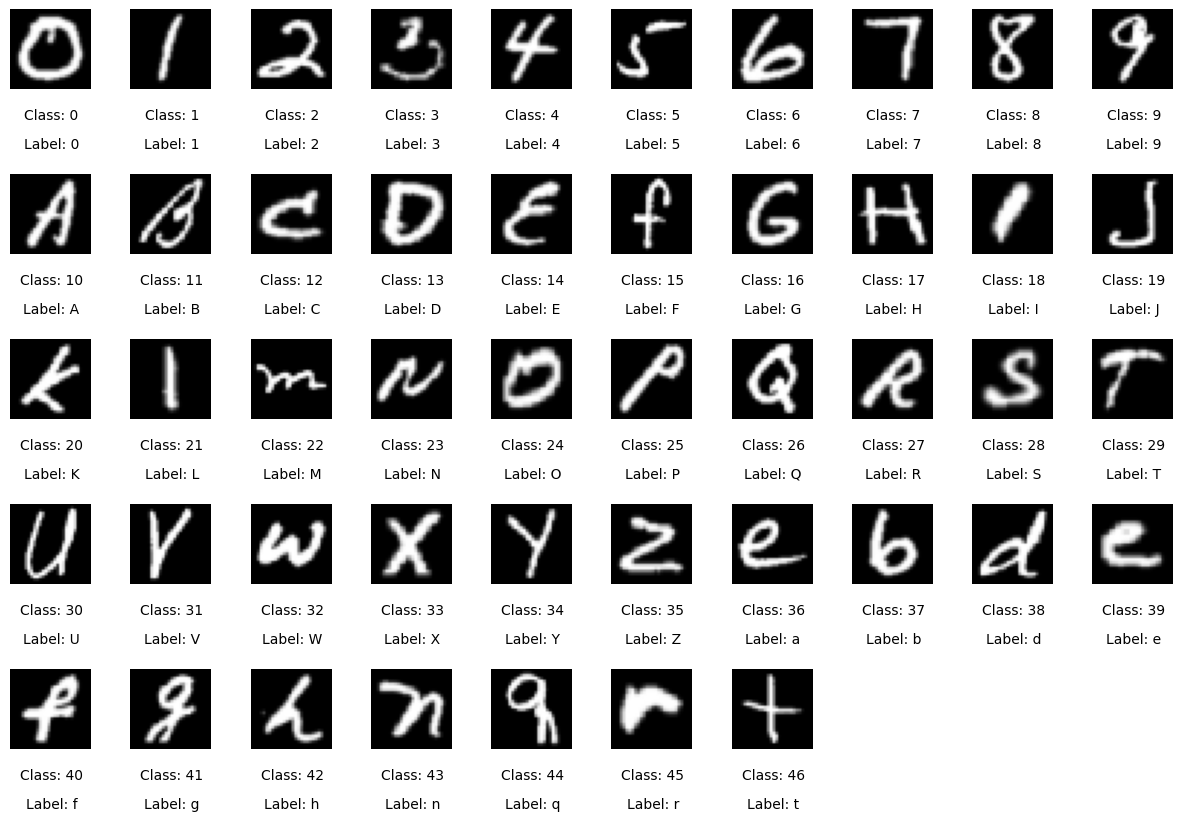

In [73]:
# 클래스 이름 추출
class_names = sorted(train_y_bymerge.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_bymerge, train_y_bymerge, class_names, mapp_bymerge)

### (c) balanced

In [5]:
train_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-train.csv",delimiter = ',')
test_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-test.csv", delimiter = ',')
mapp_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train_balanced.shape, test_balanced.shape, mapp_balanced.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [12]:
# Split x and y for balanced dataset
train_x_balanced = train_balanced.iloc[:,1:]
train_y_balanced = train_balanced.iloc[:,0]
del train_balanced

test_x_balanced = test_balanced.iloc[:,1:]
test_y_balanced = test_balanced.iloc[:,0]
del test_balanced

print(train_x_balanced.shape, train_y_balanced.shape, test_x_balanced.shape, test_y_balanced.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [22]:
# Flip and rotate image for balanced dataset
train_x_balanced = np.asarray(train_x_balanced)
train_x_balanced = np.apply_along_axis(rotate, 1, train_x_balanced)
print("train_x_balanced:", train_x_balanced.shape)

test_x_balanced = np.asarray(test_x_balanced)
test_x_balanced = np.apply_along_axis(rotate, 1, test_x_balanced)
print("test_x_balanced:", test_x_balanced.shape)

# Normalize
train_x_balanced = train_x_balanced.astype('float32')
train_x_balanced /= 255
test_x_balanced = test_x_balanced.astype('float32')
test_x_balanced /= 255


train_x_balanced: (112799, 28, 28)
test_x_balanced: (18799, 28, 28)


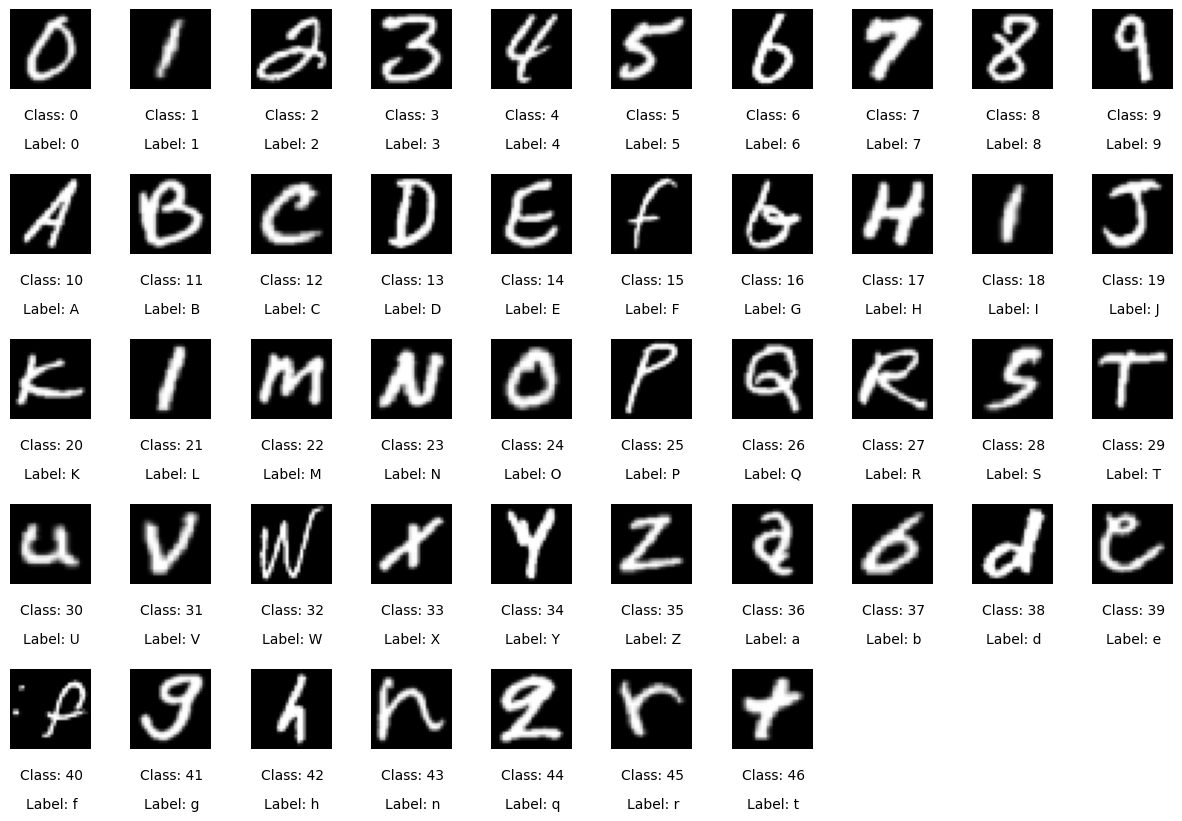

In [74]:
# 클래스 이름 추출
class_names = sorted(train_y_balanced.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_balanced, train_y_balanced, class_names, mapp_balanced)

### (d) digits

In [6]:
train_digits = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/digits/emnist-digits-train.csv",delimiter = ',')
test_digits = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/digits/emnist-digits-test.csv", delimiter = ',')
mapp_digits = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/digits/emnist-digits-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train_digits.shape, test_digits.shape, mapp_digits.shape))

Train: (239999, 785), Test: (39999, 785), Map: (10,)


In [13]:
# Split x and y for digits dataset
train_x_digits = train_digits.iloc[:,1:]
train_y_digits = train_digits.iloc[:,0]
del train_digits

test_x_digits = test_digits.iloc[:,1:]
test_y_digits = test_digits.iloc[:,0]
del test_digits

print(train_x_digits.shape, train_y_digits.shape, test_x_digits.shape, test_y_digits.shape)

(239999, 784) (239999,) (39999, 784) (39999,)


In [18]:
# Flip and rotate image
train_x_digits = np.asarray(train_x_digits)
train_x_digits = np.apply_along_axis(rotate, 1, train_x_digits)
print("train_x_digits:", train_x_digits.shape)

test_x_digits = np.asarray(test_x_digits)
test_x_digits = np.apply_along_axis(rotate, 1, test_x_digits)
print("test_x_digits:", test_x_digits.shape)

# Normalize
train_x_digits = train_x_digits.astype('float32')
train_x_digits /= 255
test_x_digits = test_x_digits.astype('float32')
test_x_digits /= 255


train_x_digits: (239999, 28, 28)
test_x_digits: (39999, 28, 28)


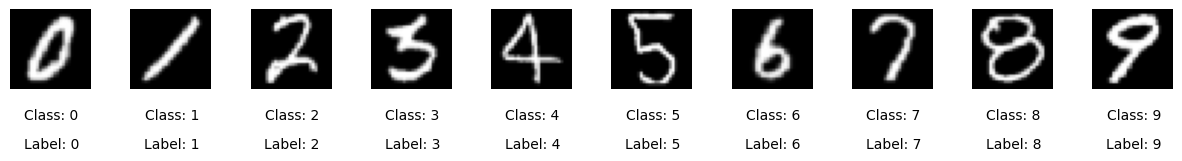

In [75]:
# 클래스 이름 추출
class_names = sorted(train_y_digits.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_digits, train_y_digits, class_names, mapp_digits)

### (e) letters

In [138]:
train_letters = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/letters/emnist-letters-train.csv",delimiter = ',')
test_letters = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/letters/emnist-letters-test.csv", delimiter = ',')
mapp_letters = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/letters/emnist-letters-mapping.txt", delimiter=' ', index_col=0, header=None, squeeze=True)

# 딕셔너리로 변환: 각 클래스 인덱스에 대응하는 대문자와 소문자를 각각 관리
expanded_mapp_letters = {}
for index, row in mapp_letters.items():
    uppercase, lowercase = row[1], row[2]
    expanded_mapp_letters[(index - 1) * 2] = chr(uppercase)  # 대문자
    expanded_mapp_letters[(index - 1) * 2 + 1] = chr(lowercase)  # 소문자
print(mapp_letters)

print("Train: %s, Test: %s, Map: %s" %(train_letters.shape, test_letters.shape, len(mapp_letters)))

     1    2
0          
1   65   97
2   66   98
3   67   99
4   68  100
5   69  101
6   70  102
7   71  103
8   72  104
9   73  105
10  74  106
11  75  107
12  76  108
13  77  109
14  78  110
15  79  111
16  80  112
17  81  113
18  82  114
19  83  115
20  84  116
21  85  117
22  86  118
23  87  119
24  88  120
25  89  121
26  90  122
Train: (88799, 785), Test: (14799, 785), Map: 26


In [115]:
# Split x and y for letters dataset
train_x_letters = train_letters.iloc[:,1:]
train_y_letters = train_letters.iloc[:,0]
del train_letters

test_x_letters = test_letters.iloc[:,1:]
test_y_letters = test_letters.iloc[:,0]
del test_letters

print(train_x_letters.shape, train_y_letters.shape, test_x_letters.shape, test_y_letters.shape)

(88799, 784) (88799,) (14799, 784) (14799,)


In [116]:
# Flip and rotate image for letters dataset
train_x_letters = np.asarray(train_x_letters)
train_x_letters = np.apply_along_axis(rotate, 1, train_x_letters)
print("train_x_letters:", train_x_letters.shape)

test_x_letters = np.asarray(test_x_letters)
test_x_letters = np.apply_along_axis(rotate, 1, test_x_letters)
print("test_x_letters:", test_x_letters.shape)

# Normalize
train_x_letters = train_x_letters.astype('float32')
train_x_letters /= 255
test_x_letters = test_x_letters.astype('float32')
test_x_letters /= 255

train_x_letters: (88799, 28, 28)
test_x_letters: (14799, 28, 28)


In [148]:
# 클래스별로 예시 이미지 출력
def plot_class_examples(images, labels, class_names, mapp):
    num_classes = len(class_names)
    num_rows = (num_classes // 10) + 1  # 최대 10개의 열을 가진 subplot의 행의 개수 계산
    num_cols = min(num_classes, 10)  # 최대 10개의 열을 가진 subplot의 열의 개수는 최대 클래스 개수까지
    
    plt.figure(figsize=(15, 2 * num_rows))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        example_index = class_indices[0] if class_indices.size > 0 else None  # 클래스에 속한 이미지가 있는지 확인

        plt.subplot(num_rows, num_cols, i + 1)
        if example_index is not None:
            plt.imshow(images[example_index], cmap='gray')
            plt.axis('off')
            
            # 띄어쓰기 이전과 이후 내용 분리
            first_part, second_part = divmod(class_name, 2)
            print(first_part, second_part)
            
            # 이미지와 텍스트의 좌우 정렬을 위해 text 위치 조정
            image_width = images[example_index].shape[1]
            class_text = 'Class: {}'.format(class_name)
            label_text = 'Label: {}({})'.format(chr(mapp[first_part]), chr(mapp[second_part]))
            plt.text(image_width // 2, images[example_index].shape[0] + 10, class_text, fontsize=10, ha='center')
            plt.text(image_width // 2, images[example_index].shape[0] + 20, label_text, fontsize=10, ha='center')
        else:
            plt.text(0.5, 0.5, 'No image', fontsize=10, ha='center', va='center')
            plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # subplot 간격 조정
    plt.show()

0 1


KeyError: 0

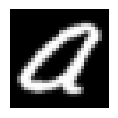

In [149]:
# 클래스 이름 추출
class_names = sorted(train_y_letters.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_letters, train_y_letters, class_names, mapp_letters)

### (6) mnist

In [111]:
train_mnist = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/mnist/emnist-mnist-train.csv",delimiter = ',')
test_mnist = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/mnist/emnist-mnist-test.csv", delimiter = ',')
mapp_mnist = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/mnist/emnist-mnist-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)

print("Train: %s, Test: %s, Map: %s" %(train_mnist.shape, test_mnist.shape, mapp_mnist.shape))

Train: (59999, 785), Test: (9999, 785), Map: (10,)


In [15]:
# Split x and y for mnist dataset
train_x_mnist = train_mnist.iloc[:,1:]
train_y_mnist = train_mnist.iloc[:,0]
del train_mnist

test_x_mnist = test_mnist.iloc[:,1:]
test_y_mnist = test_mnist.iloc[:,0]
del test_mnist

print(train_x_mnist.shape, train_y_mnist.shape, test_x_mnist.shape, test_y_mnist.shape)

(59999, 784) (59999,) (9999, 784) (9999,)


In [20]:
# Flip and rotate image for mnist dataset
train_x_mnist = np.asarray(train_x_mnist)
train_x_mnist = np.apply_along_axis(rotate, 1, train_x_mnist)
print("train_x_mnist:", train_x_mnist.shape)

test_x_mnist = np.asarray(test_x_mnist)
test_x_mnist = np.apply_along_axis(rotate, 1, test_x_mnist)
print("test_x_mnist:", test_x_mnist.shape)

# Normalize
train_x_mnist = train_x_mnist.astype('float32')
train_x_mnist /= 255
test_x_mnist = test_x_mnist.astype('float32')
test_x_mnist /= 255


train_x_mnist: (59999, 28, 28)
test_x_mnist: (9999, 28, 28)


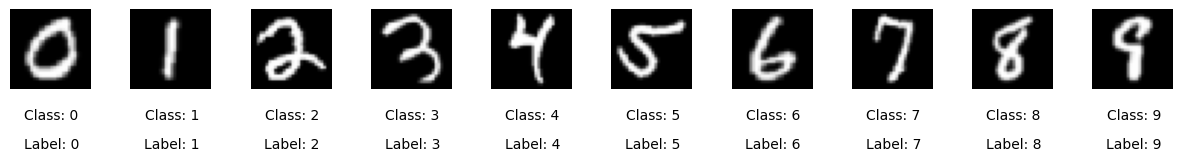

In [81]:
# 클래스 이름 추출
class_names = sorted(train_y_mnist.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_mnist, train_y_mnist, class_names, mapp_mnist)

## +) Reference

- https://www.simonwenkel.com/notes/ai/datasets/vision/EMNIST.html
- https://kh-mo.github.io/papers/2020/08/26/emnist/
- EMNIST 논문: https://arxiv.org/pdf/1702.05373v1
- NIST (EMNIST): https://www.nist.gov/itl/products-and-services/emnist-dataset
- Kaggle (EMNIST): https://www.kaggle.com/datasets/crawford/emnist?resource=download
- Visualizing the Data: https://www.kaggle.com/code/ashwani07/emnist-using-keras-cnn